In [1]:
# Author: Prashant Shinde
# Date: March 28th, 2020
# Goal: Predict # of COVID 19 'confirmed' case per day within USA

In [2]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
plt.style.use('fivethirtyeight')
%matplotlib inline 
import itertools

# feature engineering
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures

# model
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR

# model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics


In [3]:
# Read Data from 
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
#print('Shape is:', confirmed_df.shape)

# Data is of all countries
#confirmed_df['Country/Region'].unique()

# Select United States data
confirmed_df_usa = confirmed_df[confirmed_df['Country/Region'] == 'US']
confirmed_df_usa = confirmed_df_usa.reset_index(drop = True)
#print('confirmed_df_usa Shape:',confirmed_df_usa.shape )

# Drop unnecessary columns, Transpose df, rename columns
confirmed_df_usa = confirmed_df_usa.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis = 1)
confirmed_df_usa = confirmed_df_usa.T
confirmed_df_usa = confirmed_df_usa.reset_index()
confirmed_df_usa = confirmed_df_usa.reset_index()
confirmed_df_usa = confirmed_df_usa.rename(columns = {'index':'Date',
                                                     0: 'Cases',
                                                     'level_0': 'Days_Since_Started'})

confirmed_df_usa['Days_Since_Started'] = confirmed_df_usa['Days_Since_Started'] + 1
#confirmed_df_usa = confirmed_df_usa[:-1]
print('Today is {}th day since COVID19 started in USA'.format(confirmed_df_usa.shape[0] + 1))

# About data freshness
from datetime import date
today = date.today()
print("Today's date:", today)
print('COVID19 Data is till {} date'.format(confirmed_df_usa['Date'].iloc[-1]))
confirmed_df_usa.tail()


Today is 76th day since COVID19 started in USA
Today's date: 2020-04-06
COVID19 Data is till 4/5/20 date


,Days_Since_Started,Date,Cases
70,71,4/1/20,213372
71,72,4/2/20,243453
72,73,4/3/20,275586
73,74,4/4/20,308850
74,75,4/5/20,337072


In [4]:
# Get summary Statistics
confirmed_df_usa.describe()

,Days_Since_Started,Cases
count,75.000000,75.000000
mean,38.000000,32870.680000
std,21.794495,76571.205785
min,1.000000,1.000000
25%,19.500000,11.000000
50%,38.000000,60.000000
75%,56.500000,7102.000000
max,75.000000,337072.000000


In [5]:
# Datatype handling
import datetime as dt
confirmed_df_usa['Date'] = pd.to_datetime(confirmed_df_usa['Date'])

# Get Month
confirmed_df_usa['Month'] = confirmed_df_usa['Date'].dt.month

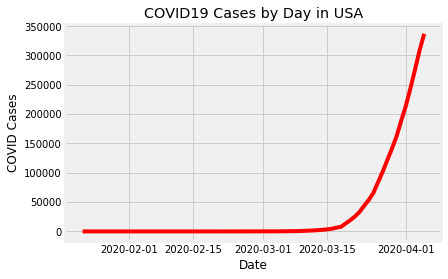

In [6]:
# Plot
plt.plot(confirmed_df_usa['Date'], confirmed_df_usa['Cases'], 'r' )
plt.title('COVID19 Cases by Day in USA')
plt.xlabel("Date") 
plt.ylabel('COVID Cases')
plt.show()


Text(0, 0.5, '# of Cases')

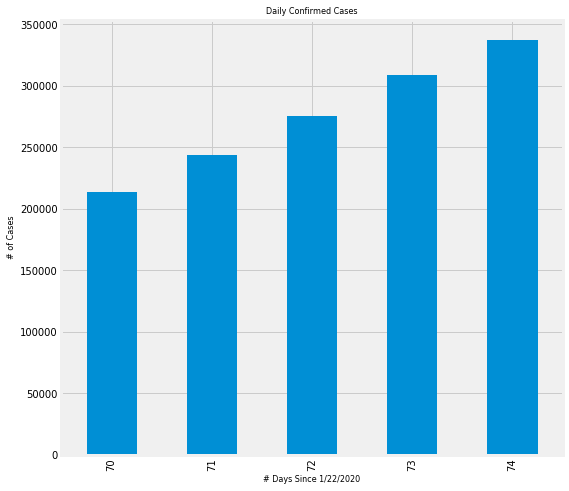

In [7]:
# Daily Cases
confirmed_df_usa.groupby('Month')['Cases'].plot.bar(fontsize=10,
                                                    figsize=(8,8))
plt.title('Daily Confirmed Cases', size=8)
plt.xlabel('# Days Since 1/22/2020', size=8)
plt.ylabel('# of Cases', size=8)

In [8]:
# Correlation between Cases & Days passed = +0.56
confirmed_df_usa.corr()

,Days_Since_Started,Cases,Month
Days_Since_Started,1.000000,0.640423,0.923588
Cases,0.640423,1.000000,0.617606
Month,0.923588,0.617606,1.000000


# Linear Regression

In [9]:
X = confirmed_df_usa[['Days_Since_Started']]
Y = confirmed_df_usa[['Cases']]
print('Shape of X_test is:', X.shape)

Shape of X_test is: (75, 1)


([], <a list of 0 Text yticklabel objects>)

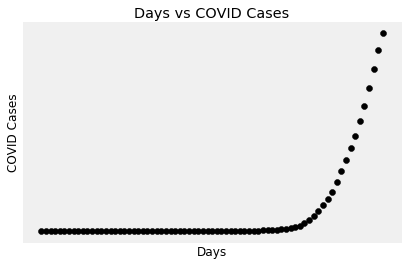

In [10]:
# Plot outputs
plt.scatter(X, Y,  color='black')
plt.title('Days vs COVID Cases')
plt.xlabel('Days')
plt.ylabel('COVID Cases')
plt.xticks(())
plt.yticks(())

In [11]:
# Split the data into training/testing sets
use_days = X.shape[0] - 2
X_train = X[:use_days] 
X_test = X[use_days:]

# Split the targets into training/testing sets
Y_train = Y[-use_days:] 
Y_test = Y[:-use_days]

print('Lets TRAIN on {}'.format(X_train.shape[0]),'examples')
print('Lets TEST on {}'.format(X_test.shape[0]),'examples')

Lets TRAIN on 73 examples
Lets TEST on 2 examples


coefficient of determination: 0.40724567804448997
intercept: [-53697.70205479]
slope: [[2364.02489819]]


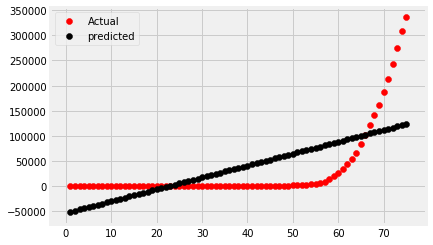

In [12]:
# Linear Model predicts COVID cases 'Linearly'

# Create linear regression object & Train
lin_model = LinearRegression().fit(X_train, Y_train)

# Plot outputs 
plt.scatter(X,Y, color = 'red', label="Actual") #Actual
plt.scatter(X, lin_model.predict(X), color = 'black', label="predicted") #Predicted
plt.legend()

# r_sq
r_sq = lin_model.score(X, Y)
print('coefficient of determination:', r_sq)

print('intercept:', lin_model.intercept_)
print('slope:', lin_model.coef_)

# Linear Model Equation
# COVID_Cases = -12863.1 + 651.3*Day

# Non-Linear Regression Techniques

In [13]:
# Create TRAIN & TEST split
days_since_started = confirmed_df_usa[['Days_Since_Started']]
usa_cases = confirmed_df_usa[['Cases']]

X_train, X_test, y_train, y_test = train_test_split(days_since_started, 
                                                    usa_cases, 
                                                    test_size=0.01, 
                                                    shuffle=False) 

print('Train Model on {} days data'.format(X_train.shape[0]))
print('Test Model on {} days data'.format(X_test.shape[0]))


Train Model on 74 days data
Test Model on 1 days data


In [14]:
# Define 'number of days in FUTURE' to predict
days_in_future = 10
future_forcast_df = np.array([i for i in range(len(confirmed_df_usa['Days_Since_Started'])+ days_in_future)]).reshape(-1, 1)
print('Total # Days in future_forcast_df is:', len(future_forcast_df))
print('Predict from 10 days:', len(future_forcast_df)-9, 'to', len(future_forcast_df))

Total # Days in future_forcast_df is: 85
Predict from 10 days: 76 to 85


# 1) Polynomial Regression

In [30]:
# Transform data for polynomial regression
poly_features = PolynomialFeatures(degree=6)

# Transfor TRAIN dataset
poly_X_train = poly_features.fit_transform(X_train)

# Transform TEST dataset
poly_X_test = poly_features.fit_transform(X_test)

# Transform FUTURE dataset
poly_future_forcast = poly_features.fit_transform(future_forcast_df)

In [31]:
# prediction % deviation from actual
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


In [32]:
# Polynomial Regression: Linear Regression with "Polynomial features"

# Define LR object
ploy_reg = LinearRegression(normalize=True, 
                                fit_intercept=False)

# Train
ploy_reg.fit(poly_X_train, y_train)
print('Fitted Model Coefficients:', ploy_reg.coef_)

# Predict X_test
y_test_pred = ploy_reg.predict(poly_X_test)
# Predict future 10 days COVID cases
future_10_days_pred = ploy_reg.predict(poly_future_forcast)

print('TEST MAE:', round(mean_absolute_error(y_test_pred, y_test),2))
print('TEST MAPE:{}%'.format(mean_absolute_percentage_error(y_test, y_test_pred)))


Fitted Model Coefficients: [[-4.57448352e+03  2.44244328e+03 -3.27269444e+02  1.70204153e+01
  -3.84054937e-01  3.43613094e-03 -6.54894471e-06]]
TEST MAE: 17923.92
TEST MAPE:5.32%


Actual: 74    337072
Name: Cases, dtype: int64
Predicted: [[354995.91833047]]


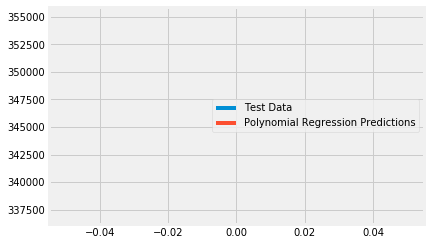

In [33]:
# Predicted TEST vs Actual Cases
print('Actual:', y_test['Cases'])
print('Predicted:', y_test_pred)

plt.plot(np.array(y_test))
plt.plot(y_test_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

Results of sklearn.metrics:
MAE: 1730.7612741122464
MSE: 4455571.783764782
RMSE: 2110.822537250534
R-Squared: 0.9990304977279832


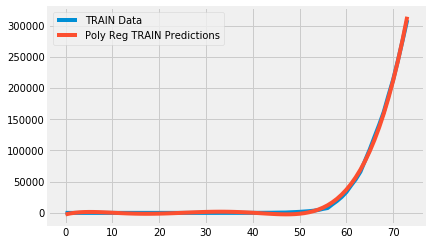

In [34]:
# TRAIN Results
y_train = y_train
y_train_pred = ploy_reg.predict(poly_X_train)

mae = metrics.mean_absolute_error(y_train, y_train_pred)
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)  
r2 = metrics.r2_score(y_train, y_train_pred)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

# Predicted TRAIN vs Actual Cases
plt.plot(np.array(y_train))
plt.plot(y_train_pred)
plt.legend(['TRAIN Data', 'Poly Reg TRAIN Predictions'])

In [35]:
# Predictions for THESE 10 days
datelist = pd.date_range(confirmed_df_usa['Date'].iloc[-1], periods=11).tolist()
datelist = datelist[1:]
datelist

[Timestamp('2020-04-06 00:00:00', freq='D'),
 Timestamp('2020-04-07 00:00:00', freq='D'),
 Timestamp('2020-04-08 00:00:00', freq='D'),
 Timestamp('2020-04-09 00:00:00', freq='D'),
 Timestamp('2020-04-10 00:00:00', freq='D'),
 Timestamp('2020-04-11 00:00:00', freq='D'),
 Timestamp('2020-04-12 00:00:00', freq='D'),
 Timestamp('2020-04-13 00:00:00', freq='D'),
 Timestamp('2020-04-14 00:00:00', freq='D'),
 Timestamp('2020-04-15 00:00:00', freq='D')]

COVID19 cases prediciton for next 10 days (starting March 27th): 
 [354996, 399804, 448714, 501975, 559850, 622606, 690522, 763883, 842984, 928129]


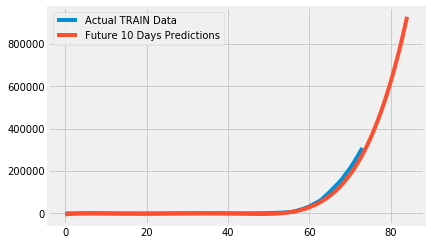

In [36]:
# FUTURE Results
y_train = y_train
future_y_pred = ploy_reg.predict(poly_future_forcast)
pred_10days =  np.around(future_y_pred[-10:], decimals=0)
pred_10days = list(itertools.chain(*pred_10days))
pred_10days = list(map(int, pred_10days))
print('COVID19 cases prediciton for next 10 days (starting March 27th): \n', pred_10days)

# Predicted Future Cases
plt.plot(np.array(y_train))
plt.plot(future_y_pred)
plt.legend(['Actual TRAIN Data', 'Future 10 Days Predictions'])

In [37]:
# Get Standard Deviation of Prediction from TRAIN

In [38]:
# Make TRAIN predictions
y_train_pred = ploy_reg.predict(poly_X_train)
y_train_pred_arr = np.array(y_train_pred)
y_train_pred_df = pd.DataFrame(data = y_train_pred_arr.flatten())
y_train_pred_df.shape

(74, 1)

In [39]:
# Generate Standard Deviation of predictions from training data
pred_stdev = np.sqrt(sum((y_train_pred_df[0] - y_train['Cases'])**2) / (len(y_train) - 2))
pred_stdev

2139.938706282761

In [40]:
# Makr future prediciotn with CI

In [41]:
# Make FUTURE predictions
future_pred = ploy_reg.predict(poly_future_forcast)
future_pred_arr = np.array(future_pred)
future_pred_df = pd.DataFrame(data = future_pred_arr.flatten())
future_pred_df = future_pred_df.rename(columns = {0: 'Cases_Pred'})
future_pred_df.shape

(85, 1)

In [42]:
# Get UPPER & LOWER limit of CI 
future_pred_df['upper_ci'] = future_pred_df['Cases_Pred'] + 1.96*pred_stdev 
future_pred_df['lower_ci'] = future_pred_df['Cases_Pred'] - 1.96*pred_stdev
future_pred_df.shape

(85, 3)

In [43]:
# Replace -ve predictions with 0 cases
future_pred_df['lower_ci'] = np.where(future_pred_df['lower_ci'] < 0, 0, future_pred_df['lower_ci'])
future_pred_df['Cases_Pred'] = np.where(future_pred_df['Cases_Pred'] < 0, 0, future_pred_df['Cases_Pred'])

# limit float to 2 decimals cases
future_pred_df = future_pred_df.round(decimals = 0)
future_pred_df = future_pred_df.astype(int)
future_pred_df = future_pred_df[1:]
future_pred_df = future_pred_df.reset_index(drop = True)


In [44]:
# Merge pred with original df 
final_df = confirmed_df_usa.merge(future_pred_df, 
                                  how='outer', 
                                  left_index=True, 
                                  right_index=True)

#
final_df = final_df.reset_index()
final_df['Days_Since_Started'] = final_df['index'] + 1
del final_df['index']
del final_df['Month']
del final_df['Date']

# Generate date column
date_list = pd.date_range(start='22/01/2020', periods = final_df.shape[0])
date_list

#
final_df = final_df.set_index(date_list)
final_df = final_df.reset_index()
final_df = final_df.rename(columns =  {'index':'Date', 
                                      'Cases': 'Actual_Cases'})

# Save predicitons 
final_df.to_csv('COVID_Predictions_USA.csv', encoding = 'UTF-8')

#
final_df.tail(18)

,Date,Days_Since_Started,Actual_Cases,Cases_Pred,upper_ci,lower_ci
66,2020-03-28,67,121478.0,116730,120924,112536
67,2020-03-29,68,140886.0,136786,140981,132592
68,2020-03-30,69,161807.0,159231,163425,155036
69,2020-03-31,70,188172.0,184248,188442,180054
70,2020-04-01,71,213372.0,212033,216227,207838
71,2020-04-02,72,243453.0,242786,246980,238591
72,2020-04-03,73,275586.0,276717,280911,272523
73,2020-04-04,74,308850.0,314045,318239,309851
74,2020-04-05,75,337072.0,354996,359190,350802
75,2020-04-06,76,NaN,399804,403999,395610


# PLOT

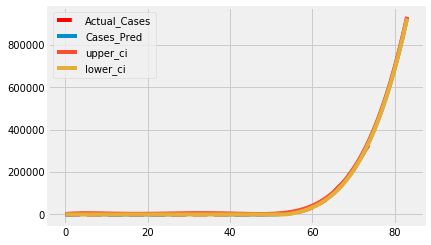

In [45]:
# Predicted TRAIN vs Actual Cases
plt.plot(np.array(final_df['Actual_Cases']), 'r--')
plt.plot(np.array(final_df['Cases_Pred']))
plt.plot(np.array(final_df['upper_ci']))
plt.plot(np.array(final_df['lower_ci']))

plt.legend(['Actual_Cases', 'Cases_Pred', 'upper_ci', 'lower_ci' ])



Text(0, 0.5, '# of Cases')

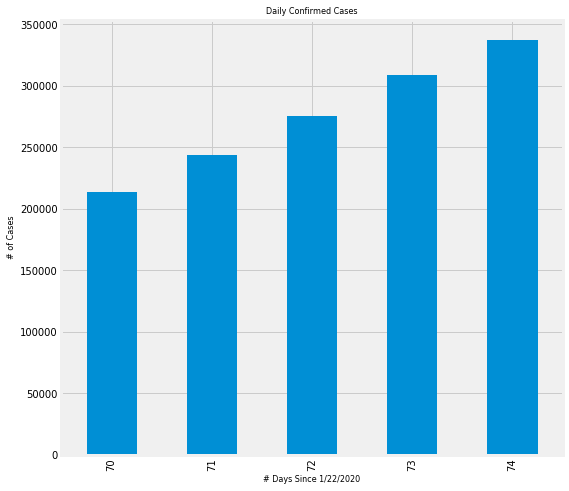

In [46]:
# Daily Cases
confirmed_df_usa.groupby('Month')['Cases'].plot.bar(fontsize=10,
                                                    figsize=(8,8))
plt.title('Daily Confirmed Cases', size=8)
plt.xlabel('# Days Since 1/22/2020', size=8)
plt.ylabel('# of Cases', size=8)

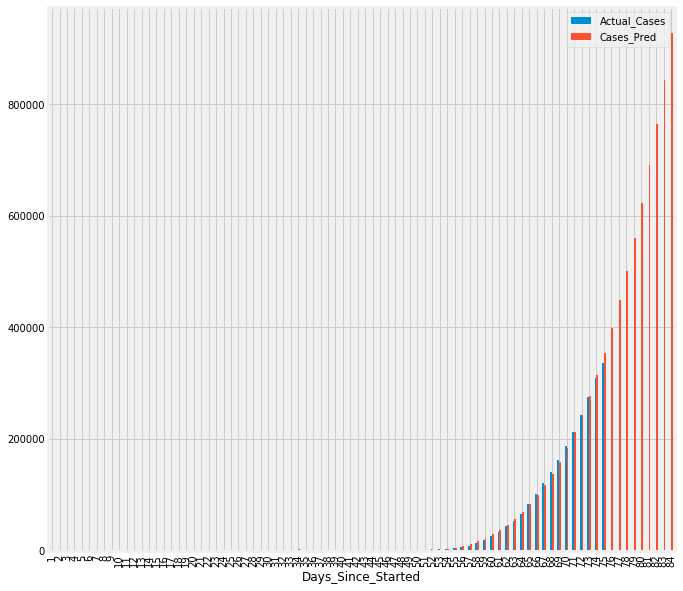

In [47]:
final_df[["Days_Since_Started", 'Actual_Cases','Cases_Pred']].plot(x="Days_Since_Started", 
                                                                   kind="bar",
                                                                   figsize=(10,10))
